# Wordle Solver

### Data: https://www.kaggle.com/datasets/bcruise/wordle-valid-words

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from copy import deepcopy
from tqdm import tqdm

np.random.seed(42)
random.seed(42)

df_solutions = pd.read_csv('valid_solutions.csv')

word_list = df_solutions['word'].tolist()
random.shuffle(word_list)

In [45]:
def print_stats(data):
    df = pd.DataFrame(data, columns=['guesses_num', 'time'])
    print(df.describe()[1:])
    
def show_dist(arrays, names, log_x=False, log_y=False, x_range=None, hist=False):
    df_compare = pd.DataFrame(
        np.array(
            arrays,
            dtype=np.int32
        ).T,
        columns=[*names]
    )

    if hist:
        sns.histplot(df_compare, bins=100, palette='rocket')
    else:
        sns.displot(df_compare, kind='kde', fill=True, palette='rocket')
    plt.xlabel('Number of guesses')
    if log_x:
        plt.xscale('log')
    if log_y:
        plt.yscale('log')
    if x_range:
        plt.xlim(x_range)
    plt.title('Number of guesses distribution')
    plt.show()

# Algorithm Validator

In [4]:
def validate_ans(ans: str, word: str) -> list:
    output = [0 for _ in range(len(word))]
    new_ans = ''
    new_word = ''
    new_idx = []
    
    for i in range(len(word)):
        if ans[i] == word[i]:
            output[i] = 2
        else:
            new_ans += ans[i]
            new_word += word[i]
            new_idx.append(i)
            
    for i in range(len(new_ans)):
        if new_ans[i] in new_word and new_ans[:i].count(new_ans[i]) < new_word.count(new_ans[i]):
            output[new_idx[i]] = 1
        else:
            output[new_idx[i]] = 0
        
    return output
            
assert validate_ans('aabaa', 'ababa') == [2, 1, 1, 0, 2]
assert validate_ans('aabad', 'ababa') == [2, 1, 1, 1, 0]
assert validate_ans('ababa', 'ababa') == [2, 2, 2, 2, 2]
assert validate_ans('ababa', 'babab') == [1, 1, 1, 1, 0]
assert validate_ans('bbbbb', 'aaaaa') == [0, 0, 0, 0, 0]

In [27]:
def validate_algorithm(f, word_list=word_list, start_word=None, show_loop=True):
    guesses_stats = []
    
    for word in tqdm(
        word_list,
        desc='Validating algorithm',
        total=len(word_list),
        bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}',
        unit=' guessed words'
        ) if show_loop else word_list:
        
        guesses_num = 0
        ans, ans_info = [], []
        
        while True:
            guess = f(ans, ans_info, start_word=start_word) if start_word else f(ans, ans_info)
            ans.append(guess)
            
            ans_info_update = validate_ans(guess, word)
            ans_info.append(deepcopy(ans_info_update))
            
            guesses_num += 1
            if guess == word:
                guesses_stats.append(guesses_num)
                break
            
    return guesses_stats

## Random Approach with Partial Information (RAwPI)

In [7]:
def rawpi_guess(
    ans: list=[], 
    ans_info: list=[],
    word_list: list=word_list,
    ):
    possible_ans = list(set(word_list) - set(ans))
    if ans_info:
        for i in range(len(ans_info[-1])):
            if ans_info[-1][i] == 0:
                possible_ans = [word for word in possible_ans if word[i] == ans[-1][i]]
    return possible_ans[0]

In [8]:
rawpi_stats = np.array(validate_algorithm(rawpi_guess)).T

Validating algorithm: 100%|████████████████████| 2315/2315 [00:05<00:00, 397.22 guessed words/s]


In [9]:
print_stats(rawpi_stats)

      guesses_num      time
mean    11.352916  0.002510
std      6.173404  0.001468
min      1.000000  0.000133
25%      7.000000  0.001560
50%     10.000000  0.002211
75%     14.000000  0.003068
max     54.000000  0.013119


/tmp/ipykernel_3144868/4099370943.py:21: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(x_range)


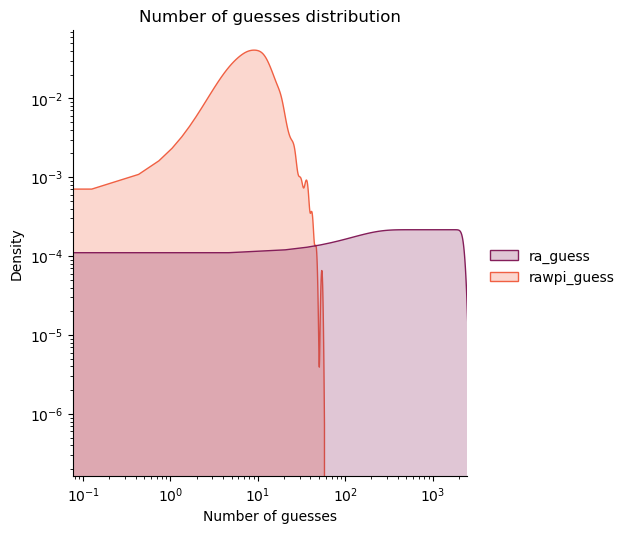

In [10]:
show_dist(
    arrays=[ra_stats[:, 0], rawpi_stats[:, 0]],
    names=['ra_guess', 'rawpi_guess'],
    x_range=(0, 2500),
    log_x=True,
    log_y=True
)

## Random Approach with Complete Information (RAwCI)

In [11]:
def rawci_guess(
    ans: list=[], 
    ans_info: list=[],
    word_list: list=word_list,
    ):
    possible_ans = list(set(word_list) - set(ans))
    if ans_info:
        for i in range(len(ans_info[-1])):
            if ans_info[-1][i] == 0:
                possible_ans = [word for word in possible_ans if word[i] == ans[-1][i]]
            elif ans_info[-1][i] == 1:
                possible_ans = [word for word in possible_ans if word[i] != ans[-1][i]]
                possible_ans = [word for word in possible_ans if ans[-1][i] in word]
            elif ans_info[-1][i] == 2:
                possible_ans = [word for word in possible_ans if word[i] != ans[-1][i]]
                possible_ans = [word for word in possible_ans if ans[-1][i] not in word]
                
    return possible_ans[0]

In [12]:
rawci_stats = np.array(validate_algorithm(rawci_guess)).T

Validating algorithm: 100%|████████████████████| 2315/2315 [00:06<00:00, 385.11 guessed words/s]


In [13]:
print_stats(rawci_stats)

      guesses_num      time
mean     5.719654  0.002588
std      2.885083  0.001628
min      1.000000  0.000134
25%      4.000000  0.001520
50%      5.000000  0.002250
75%      7.000000  0.003225
max     40.000000  0.021033


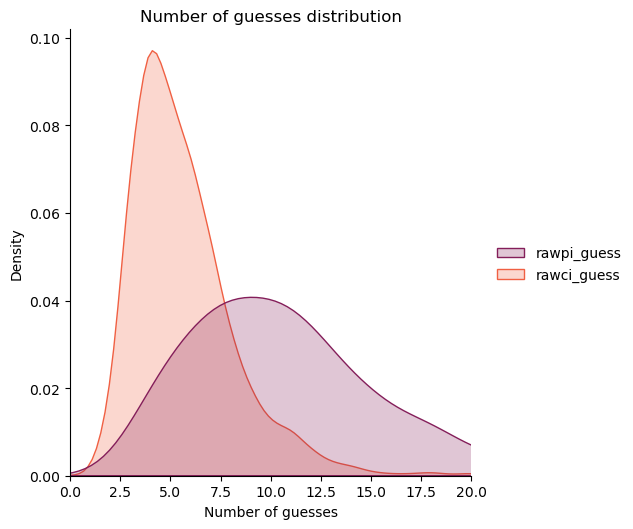

In [14]:
show_dist(
    arrays=[rawpi_stats[:, 0], rawci_stats[:, 0]],
    names=['rawpi_guess', 'rawci_guess'],
    x_range=(0, 20)
)

## Word Frequency Improvement (WFI)

In [15]:
def wfi_guess(
    ans: list=[], 
    ans_info: list=[],
    word_list: list=word_list,
    ):
    possible_ans = list(set(word_list) - set(ans))        
    if ans_info:
        for i in range(len(ans_info[-1])):
            if ans_info[-1][i] == 0:
                possible_ans = [word for word in possible_ans if word[i] == ans[-1][i]]
            elif ans_info[-1][i] == 1:
                possible_ans = [word for word in possible_ans if word[i] != ans[-1][i]]
                possible_ans = [word for word in possible_ans if ans[-1][i] in word]
            elif ans_info[-1][i] == 2:
                possible_ans = [word for word in possible_ans if word[i] != ans[-1][i]]
                possible_ans = [word for word in possible_ans if ans[-1][i] not in word]
                
    prob_matrix = np.zeros((26, 5))
    for word in possible_ans:
        for i in range(len(word)):
            prob_matrix[ord(word[i]) - ord('a')][i] += 1
    
    maxi = -1
    top_ans = None
    for i in range(len(possible_ans)):
        output = 1
        for j in range(len(possible_ans[i])):
            if ans_info and ans_info[-1][j] == 0: continue
            x = prob_matrix[ord(possible_ans[i][j]) - ord('a')][j]
            output *= x
        if output > maxi:
            maxi = output
            top_ans = deepcopy(possible_ans[i])
            
    return top_ans

In [16]:
wfi_stats = np.array(validate_algorithm(wfi_guess)).T

Validating algorithm: 100%|████████████████████| 2315/2315 [00:20<00:00, 110.81 guessed words/s]


In [17]:
print_stats(wfi_stats)

      guesses_num      time
mean     5.156803  0.008998
std      3.061180  0.002169
min      1.000000  0.006360
25%      3.000000  0.007728
50%      4.000000  0.008499
75%      6.000000  0.009605
max     73.000000  0.049291


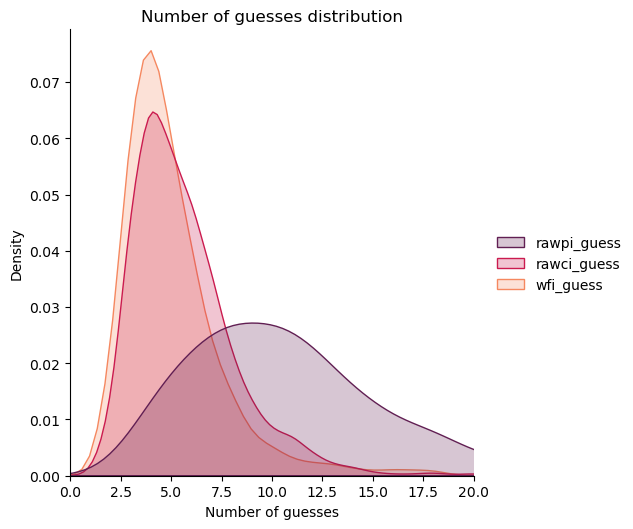

In [18]:
show_dist(
    arrays=[rawpi_stats[:, 0], rawci_stats[:, 0], wfi_stats[:, 0]],
    names=['rawpi_guess', 'rawci_guess', 'wfi_guess'],
    x_range=(0, 20)
)

## Fixing first word (FFW)

In [77]:
def ffw_guess(
    ans: list=[], 
    ans_info: list=[],
    word_list: list=word_list,
    start_word: str="cloud"
    ):
    if not ans:
        return start_word
    
    possible_ans = list(set(word_list) - set(ans))        
    if ans_info:
        for i in range(len(ans_info[-1])):
            if ans_info[-1][i] == 0:
                possible_ans = [word for word in possible_ans if word[i] == ans[-1][i]]
            elif ans_info[-1][i] == 1:
                possible_ans = [word for word in possible_ans if word[i] != ans[-1][i]]
                possible_ans = [word for word in possible_ans if ans[-1][i] in word]
            elif ans_info[-1][i] == 2:
                possible_ans = [word for word in possible_ans if word[i] != ans[-1][i]]
                possible_ans = [word for word in possible_ans if ans[-1][i] not in word]
                
    prob_matrix = np.zeros((26, 5))
    for word in possible_ans:
        for i in range(len(word)):
            prob_matrix[ord(word[i]) - ord('a')][i] += 1
    
    maxi = -1
    top_ans = None
    for i in range(len(possible_ans)):
        output = 1
        for j in range(len(possible_ans[i])):
            if ans_info and ans_info[-1][j] == 0: continue
            x = prob_matrix[ord(possible_ans[i][j]) - ord('a')][j]
            output *= x
        if output > maxi:
            maxi = output
            top_ans = deepcopy(possible_ans[i])
            
    return top_ans

In [39]:
def validate_first_word(
    f: callable,
    word_list: list=word_list,
    ):
    output = []
    for start_word in tqdm(
        word_list,
        desc='Checking first word',
        total=len(word_list),
        bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}',
        unit=' checked words'
        ):
        val_stats = np.array(validate_algorithm(
            f,
            start_word=start_word,
            show_loop=False
        )).T
        output.append(val_stats.copy())
    return output

In [40]:
data = validate_first_word(ffw_guess)

Checking first word: 100%|████████████████████| 2315/2315 [4:40:09<00:00,  7.26s/ checked words]  


In [79]:
avg_per_word = []
ok_per_word = []
maxi_per_word = []
for x in data:
    avg_per_word.append(np.mean(x[:, 0].copy()))
    ok_per_word.append(np.sum(x[:, 0].copy() <= 6))
    maxi_per_word.append(np.max(x[:, 0].copy()))
    
print("Best word:", word_list[np.argmax(ok_per_word)])

Best word: cloud


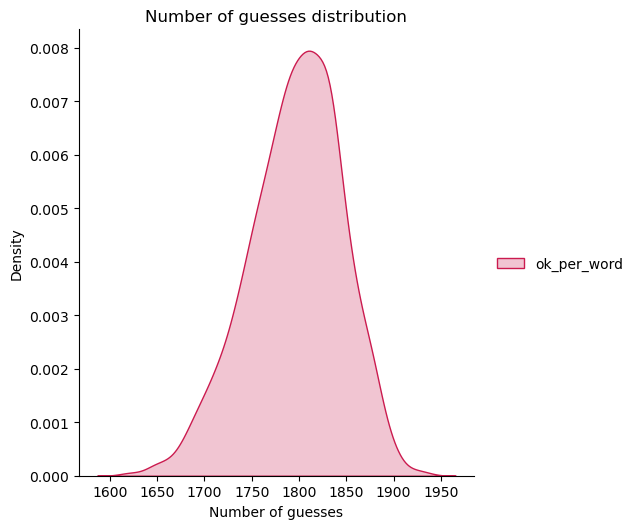

In [80]:
show_dist(
    arrays=[ok_per_word],
    names=['ok_per_word'],
)

In [81]:
ffw_stats = np.array(validate_algorithm(ffw_guess)).T

Validating algorithm: 100%|████████████████████| 2315/2315 [00:06<00:00, 364.30 guessed words/s]


In [82]:
print_stats(ffw_stats)

      guesses_num      time
mean     5.049676  0.002734
std      2.844371  0.002006
min      1.000000  0.000004
25%      4.000000  0.001472
50%      4.000000  0.002326
75%      6.000000  0.003564
max     74.000000  0.044503


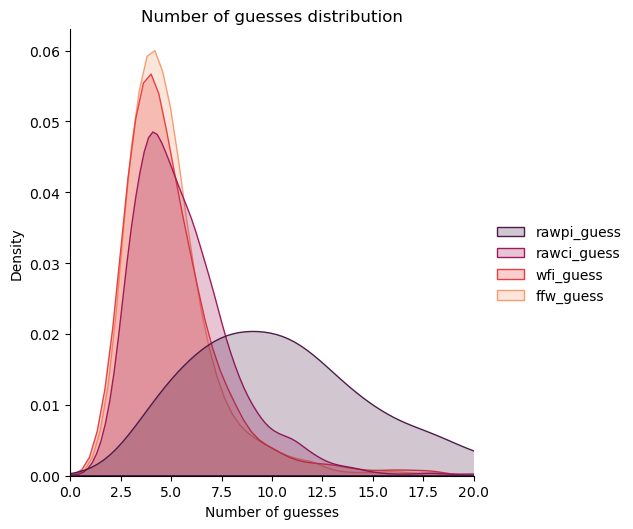

In [83]:
show_dist(
    arrays=[rawpi_stats[:, 0], rawci_stats[:, 0], wfi_stats[:, 0], ffw_stats[:, 0]],
    names=['rawpi_guess', 'rawci_guess', 'wfi_guess', 'ffw_guess'],
    x_range=(0, 20)
)